## Monte Carlo Methods

\
\### Table of Contents: 
* [Calculate Pi by MC](#Calculate-Pi-by-MC)
* [The Riemann Integral](#The-Riemann-Integral)
* [Integrals by MC](#Integrals-by-MC)
* [Black Scholes Formula for a European Call](#Black-Scholes-Formula-for-a-European-Call)
* [Solution of the GBM Stochastic DE](#Solution-of-the-GBM-Stochastic-DE)
* [Ornstein Uhlenbeck Equation (Mean Reverting)](#Ornstein-Uhlenbeck-Equation-Mean-Reverting)
* [CIR Equation](#CIR-Equation)
* [Estimating Volatility on Real Data](#Estimating-Volatility-on-Real-Data)
* [Implied Volatility](#Implied-Volatility)

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


### Calculate Pi by MC

In [ ]:
%%timeit
#Using a loop
N=1800000
count=0
points=np.random.uniform(-1,1,(N,2))
for i in np.arange(N):
    if points[i,0]**2+points[i,1]**2 <=1:
        count+=1
print(4*count/N)

In [ ]:
%%timeit
#Using  'where'
N=18000000
points=np.random.uniform(-1,1,(N,2))
count=np.where(points[:,0]**2+points[:,1]**2<=1,1,0).sum()
print(4*count/N)

In [ ]:
%%timeit
#Vectorising
N=1800000
points=np.random.uniform(-1,1,(N,2))
points=points[:,0]**2+points[:,1]**2
points=points[points<=1]
print(4*len(points)/N)

In [ ]:
#### Time for above 3: 4 seconds, 1.5 seconds, 0.2seconds

### The Riemann Integral
We split the interval  $[0,T]$  into  $N$  intervals, each of width  $Δt=T/N$,
$0=t_0<t_1<⋯<t_i<⋯<t_N=T$. Note that there are $N+1$ points $t_i$. We define the Riemann Integral by
$$\int_0^T f(t)\,dt=\lim_{N\to\infty}\sum_{i=0}^{N-1}f(t_i)\Delta t$$
Note that we could have also used a partition of varying $\Delta t$ and $f(\xi_i),t_i\le\xi_i\le t_{i+1}$ 
but we will need this definition when we extend to stochastic integrals.

We know from elementary calculus that $\int_0^\pi (2+\cos t)\,dt=[2t+\sin\ t]_0^\pi=2\pi+\sin\pi=2\pi,\ \int_0^Tt^5\,dt=\frac16 T^6$.     
We calculate straight from the definition.

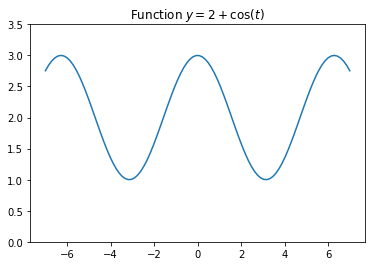

In [ ]:
T=7;N=100
t=np.linspace(-T,T,N)
plt.plot(t,2+np.cos(t))
plt.ylim([0,3.5])
plt.title(r'Function $y=2+\cos(t)$')
plt.show()

In [ ]:
%%timeit
N=10000000
T=np.pi
dt=T/(N-1)

t=np.linspace(0,T,N)

Int=dt*np.sum(2+np.cos(t))

print(Int)
print(2*np.pi)

In [ ]:
%%timeit
N=10000000
T=4
dt=T/(N-1)

t=np.linspace(0,T,N)

Int=dt*np.sum(t**5)

print(Int)
print((1/6)*(T**6))

### Integrals by MC

For a random variable $X$ with density $p(x)dx$ for x in $[a,b]$ the expected value of $f(X)$
(for some "nice" function f) is the integral
$$E(f(X))=\int_a^bf(x)p(x)\,dx$$
In the case of a uniform distribution 
$$p(x)dx= = \frac1{b-a}dx$$
So 
$$ \int_a^bf(x)\,dx= (b-a)E(f(X))$$
Using the Law of Large Numbers, we have
$$(b-a)E(f(X))=(b-a)\lim_{n\to\infty}\frac1n\sum_{i=0}^{n-1}f(\xi_i)= \int_a^bf(x)\,dx$$
where the $\xi_i$are draws from $n$ independent uniform variables (the limit is taken in the special sense that convergence takes place everyhere except for a set of events of probability 0 - it is valid also for any other probability distribution provided the rv's have finite expectation of their absolute values).
This leads to the Monte Carlo method of evaluating integrals below. 

The variance of the estimate is easily calculated and is equal to $\sigma^2_{f(X)}/n$. 
The standard error is $\sigma_{f(X)}/\sqrt{n}$.  
An estimate for $σ_{f(X)}^2$ is $\frac1{n − 1}\sum_0^{n-1}(f(Ui) − \hat I_f )^2$ where $\hat I_f$ is the estimate of the integral.


In [ ]:
%%timeit
# Integral of sin(t) over [0,pi] is 2
N=1000000
lowlim=0
uplim=np.pi
f=np.sin
points=np.random.uniform(0,np.pi,N)
Int=((uplim-lowlim)/N)*(f(points)).sum()
print(Int)

# BS Formula for a European Call

\begin{align}
d1&=\frac{\log\frac{S_0}K + (r+\frac12\sigma^2)T}{\sigma\sqrt{T}}\\
d2&=\frac{\log\frac{S_0}K + (r-\frac12\sigma^2)T}{\sigma\sqrt{T}}\\
CV&=S_0N(d1)-Ke^{-rT}N(d2)
\end{align}
($N(x)$ is the Standard Normal Probability Density Function (pdf)).  
**Note** that the price depends only on the valatility (stock-dependent) and all the rest of the parameters are either market parameters or chosen by the buyer/seller of the option.

In [ ]:
def bsm_call_val(S0, K, T, r, sigma):
    ''' 
    Valuation of European call option in Black Scholes model
    using the analytic formula.
    
    Parameters
    ==========
    S0 : float        initial stock/index level
    K : float         strike price
    T : float         maturity date (in year fractions)
    r : float         constant risk-free short rate
    sigma : float     volatility factor in diffusion term
    
    Returns
    =======
    value : float     present value of the European call option
    '''
    from scipy import stats
    from math import log,sqrt,exp

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
            # stats.norm.cdf --> cumulative distribution function for the normal distribution
    return value

c=bsm_call_val(100,105,1,0.05,0.2)
c

8.021352235143176

In [ ]:
def bsm_vega(S0,K, T, r,sigma):
  from math import log,sqrt
  from scipy import stats
  S0=float(S0)
  d1=log(S0/K) +(r+1/2 * sigma**2)*T/(sigma*sqrt(T))
  vega=S0*stats.norm.cdf(d1,0.0,1.0)*sqrt(T)
  return vega

In [ ]:
bsm_vega(100,105,1,0.05,0.2)

61.8372754995278

In [ ]:
import time as tm

In [ ]:
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
t0=tm.time()
bsm_call_val(S0, K, T, r, sigma)
t0=tm.time()-t0
print('Time to run this code segment = %5.5f' % t0)

# Plotting Brownian Motions and GBM

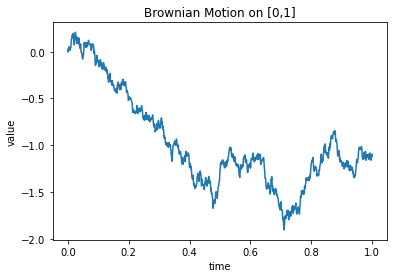

In [ ]:
N=1001
T=1
dt=1/(N-1)
t=np.linspace(0,1,N)
w=np.sqrt(dt)*np.random.randn(N)
w=w.cumsum()
plt.plot(t,w)
plt.title('Brownian Motion on [0,1]')
plt.xlabel('time')
plt.ylabel('value')
plt.show()

Text(0, 0.5, 'Value')

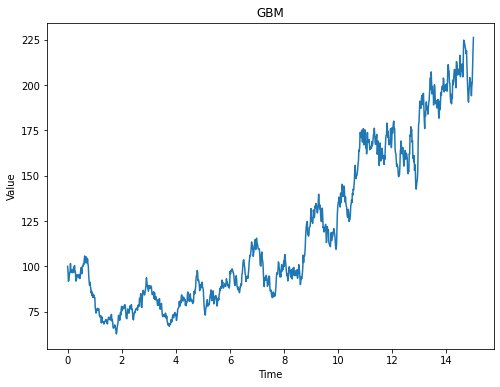

In [ ]:
import numpy as np
S0 = 100.
K = 105.
T = 15.0
r = 0.05
sigma = 0.2

I = 1000
dt=T/(I+1)
t=np.linspace(0,T,I)

St=np.zeros(I)
St[0]=S0
z=np.random.randn(I)
for i in range(1,1000):
  St[i] = St[i-1] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * z[i-1])
plt.figure(figsize=(8,6))
plt.plot(t,St)
plt.title('GBM')
plt.xlabel('Time')
plt.ylabel('Value')


### Ornstein Uhlenbeck Equation Mean Reverting

$$dS_t=rS_tdt+\sigma S_t dW_t$$

This can also be written as
$$\frac{dS}S=r dt+\sigma dW$$


This equation is understood to be an integral equation:

$$\int_0^\tau dS_t=\int_0^\tau rS_tdt+\int_0^\tau\sigma S_t dW_t$$

where $W_t$ is a stochastic variable called a Wiener Process or a Brownian Motion. There is an analytic solution:

$$S(t)=S(0)e^{(r-\frac12\sigma^2)t+\sigma W(t)}$$

For each Brownian Motion path of shocks $W(t)$  we get a different solution path.

**Note** The parameter $r$ in the $r\,dt$ term represents interest rate. It is also the rate of growth of money left in a bank.
The real expected rate of growth of the stock is, strangely, not present in pricing options. This comes out in the pricing theory of options and will be dealt with later. 

We discretise the equation for numerical solution using an Euler scheme and the fact that 
$W(t+\Delta t)-W(t)=\sqrt{\Delta t}z$
where z is a standard normal variable - we replace $df$ by $\Delta f=f(t+\Delta t)-f(t)$ in each term.

\begin{align}
S[t+\Delta t]-S[t]&= rS(t)\Delta t + \sigma S[t](W(t+\Delta t)-W(t))\\
S[t+\Delta t]&=S[t](1+ r\Delta t + \sigma\sqrt{\Delta t}z)
\end{align}

We split the interval $[0,T]$ into $N$ intervals, each of width $\Delta t$ by inserting points $t_i,\ 1\le i\le N$ 
denoted by $0=t_0<t_1<\dots<t_i<\dots <t_N=T$

Set S[0]=S_0 and use the last equation to solve successively for $S[t_1],S[t_2],\dots,S[t_N]=S[T]$, We need to draw an independent value from a standard normal distribution at each step to get $z$.

\begin{align}
dr&=a(b-r)dt+\sigma dW\\
r(t+\Delta t)&=r(t)+a(b-r(t))\Delta t+\sigma\sqrt{\Delta t}\,z
\end{align}

**Note** With different parameters, there is a a fair probability that the rate will go negative, which has 
not been historically frequent. The CIR model below can avoid this.

### CIR Equation

\begin{align}
dr&=a(b-r)dt+\sigma\sqrt{r}dW\\
r(t+\Delta t)&=r(t)+a(b-r(t))\Delta t+\sigma\sqrt{r(t)}\sqrt{\Delta t}\,z
\end{align}

**Note** It can be shown that if $2ab>\sigma^2$ the continuous solution does not go negative. Unfortunately, this need not hold 
for the discretised version used in numerical computation.

### Estimating Volatility on Real Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
goog1=pd.read_csv('/content/drive/MyDrive/AIMS_Course_March_2021+2022_FinMath_FINAL/FinMath2022_Complete/DATA/GOOG.csv')

In [ ]:
goog1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-09,231.698029,235.170441,228.980698,231.941452,231.941452,25750100
1,2006-01-10,230.709457,233.605621,229.527145,233.362198,233.362198,18312400
2,2006-01-11,234.112320,236.019913,233.074081,234.291168,234.291168,18131900
3,2006-01-12,235.329407,235.960312,229.258896,230.317017,230.317017,20382200
4,2006-01-13,230.654816,231.936478,229.313538,231.618546,231.618546,15412700


In [ ]:
goog=pd.DataFrame()
goog1.index=goog1['Date']
goog['Adj Close']=goog1['Adj Close']
goog.index=goog1.index
goog.head()

,Adj Close
Date,
2006-01-09,231.941452
2006-01-10,233.362198
2006-01-11,234.291168
2006-01-12,230.317017
2006-01-13,231.618546


In [ ]:
goog['Log_Ret'] = np.log(goog['Adj Close'] / goog['Adj Close'].shift(1))
goog['Volatility'] = goog['Log_Ret'].rolling(20).std(window=252)* np.sqrt(252)

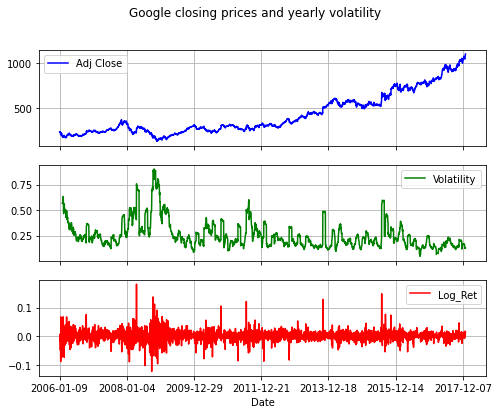

In [ ]:
# gives annual std's - 252 trading days in year approximately
goog[['Adj Close', 'Volatility','Log_Ret']].plot(subplots=True, color=['blue','green','red'],
                                   figsize=(8, 6), grid=True,title="Google closing prices and yearly volatility");

### Implied Volatility

As remarked previously, the BS formula for option pricing contains only one parameter, the volatility $\sigma$, which 
does not come from the market or is chosen by the buyer/seller. It can be shown that the relation between option price 
and volatility is 1-1 onto (bijective). 
For each sigma, the option pricing equation gives a value of the option price, and for each price there is a unique sigma giving this price via the formula.

Given a price we write a program to find the corresponding sigma, which involves inverting the pricing equation, which is nonlinear and therefore requires Newton's method or some other approximate method of solving the problem. This corresponding value of sigma is often quoted by markets instead of the price and is called the **Implied Volatility**.

## Newton's Method to solve f($\sigma$) = C

$\sigma_{n+1}$ = $\sigma_n$ - (f($\sigma$_n)-C)/((df/d$\sigma$)($\sigma_n$))

In [ ]:
def bsm_vega(S0,K, T, r,sigma):
  from math import log,sqrt
  from scipy import stats
  S0=float(S0)
  d1=log(S0/K) +(r+1/2 * sigma**2)*T/(sigma*sqrt(T))
  vega=S0*stats.norm.cdf(d1,0.0,1.0)*sqrt(T)
  return vega

In [ ]:
def bsm_call_imp_vol(S0,K, T,C0, sigma_est,nit=100):
  for i in range(nit):
    bsm_c=bsm_call_val(S0,K, T, r, sigma_est)
    bsm_v=bsm_vega(S0,K, T, r, sigma)
    sigma_est -= (bsm_c-C0)/bsm_v
  return sigma_est

In [ ]:
bsm_call_imp_vol(100,105,1,10,0.3)